In [1]:
from glob import glob
import pandas as pd

In [2]:
columns = ['price', 'quantity', 'timestamp', 'is_buyer_maker']

spot_df = []
derivative_df = []

for file in glob('data/*'):
    if 'spot' in file:
        spot_df.append(pd.read_csv(file, header=None))
    else:
        derivative_df.append(pd.read_csv(file, header=None)[1:])

spot_df = pd.concat(spot_df)[[1, 2, 5, 6]].reset_index(drop=True)
derivative_df = pd.concat(derivative_df)[[1, 2, 5, 6]].reset_index(drop=True)

spot_df.columns = columns
derivative_df.columns = columns



spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'], unit='ms')
derivative_df['timestamp'] = pd.to_datetime(derivative_df['timestamp'], unit='ms')


spot_df = spot_df.sort_values('timestamp').reset_index(drop=True)
derivative_df = derivative_df.sort_values('timestamp').reset_index(drop=True)


derivative_df['derivative_price'] = derivative_df['price']


/tmp/ipykernel_78244/1821862887.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  derivative_df.append(pd.read_csv(file, header=None)[1:])
/tmp/ipykernel_78244/1821862887.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  derivative_df.append(pd.read_csv(file, header=None)[1:])
/tmp/ipykernel_78244/1821862887.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  derivative_df.append(pd.read_csv(file, header=None)[1:])


In [3]:
spot_df = spot_df[:50000]

In [4]:
df = pd.merge_asof(spot_df[['timestamp', 'price', 'quantity', 'is_buyer_maker']], derivative_df[['timestamp', 'derivative_price']], on='timestamp')

In [20]:
params = {}
params['capital'] = 20000
params['maxPositionSize'] = 10000

curr_pos = 0
hedge_pos = 0
deets = []


for idx, row in df.iterrows():
    curr_deets = {}

    if (idx % 100) == 0:
        curr_deets['timestamp'] = row['timestamp']
        curr_deets['curr_pos'] = curr_pos * row['price']
        curr_deets['capital'] = params['capital']
        curr_deets['worth'] = curr_deets['curr_pos'] + curr_deets['capital']
        curr_deets['price'] = row['price']
        deets.append(curr_deets)
        
    if row['is_buyer_maker']:
        if (curr_pos * row['price']) < params['maxPositionSize']:

            buy_amt = row['quantity'] * row['price']
            quantity = row['quantity']

            if buy_amt > params['maxPositionSize']:
                buy_amt = params['maxPositionSize']
                quantity = buy_amt / row['price']

            # print("BUYING {} BTC for {} USD. Current POS: {}".format(quantity, buy_amt, curr_pos))
            curr_pos = curr_pos + quantity
            params['capital'] = params['capital'] - buy_amt
    else:
        if curr_pos > 0:
            sell_amt = row['quantity'] * row['price']
            quantity = row['quantity']

            if sell_amt > curr_pos:
                sell_amt = curr_pos
                quantity = sell_amt / row['price']

            # print("SELLING {} BTC for {} USD. Current POS: {}".format(quantity, sell_amt, curr_pos))
            curr_pos = curr_pos - quantity
            params['capital'] = params['capital'] + sell_amt

In [21]:
details_df = pd.DataFrame(deets)

<AxesSubplot: xlabel='timestamp'>

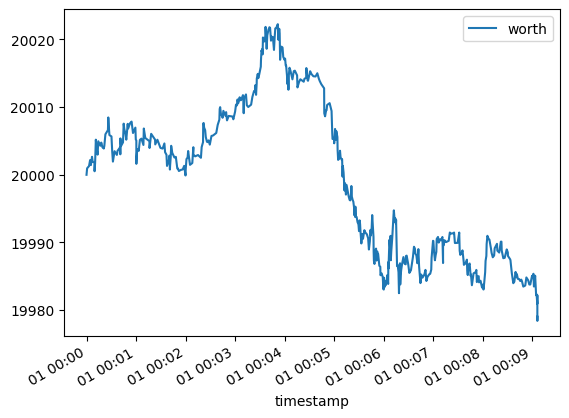

In [23]:
details_df.set_index('timestamp')[['worth']].plot()

<AxesSubplot: xlabel='timestamp'>

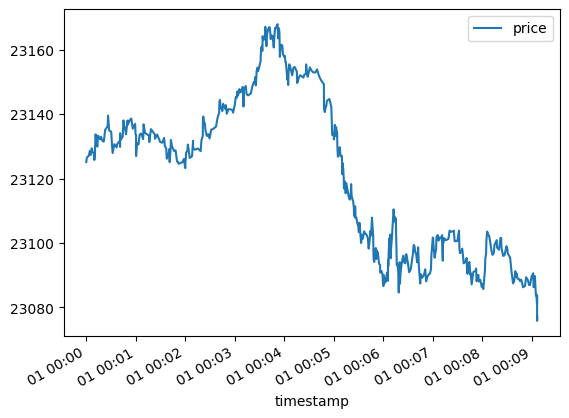

In [24]:
details_df.set_index('timestamp')[['price']].plot()